In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure,show
from bokeh.models import HoverTool
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [3]:
!kaggle datasets download -d jliazhang/lolmsi2021 -p C:\Users\coope\Data --unzip



  0%|          | 0.00/36.7k [00:00<?, ?B/s]
100%|##########| 36.7k/36.7k [00:00<00:00, 1.39MB/s]


In [2]:
file_name = 'Data/msi_matches.xlsx'
df = pd.read_excel(file_name, index_col = 0) 

In [3]:
df.columns

Index(['match_id', 'blue_team_name', 'red_team_name', 'result', 'duration',
       'duration_in_sec', 'date', 'blue_top_name', 'blue_top_champion',
       'blue_top_kills', 'blue_top_deaths', 'blue_top_assists', 'blue_top_kda',
       'blue_top_cs', 'blue_top_gd_at_15', 'blue_jg_name', 'blue_jg_champion',
       'blue_jg_kills', 'blue_jg_deaths', 'blue_jg_assists', 'blue_jg_kda',
       'blue_jg_cs', 'blue_jg_gd_at_15', 'blue_mid_name', 'blue_mid_champion',
       'blue_mid_kills', 'blue_mid_deaths', 'blue_mid_assists', 'blue_mid_kda',
       'blue_mid_cs', 'blue_mid_gd_at_15', 'blue_bot_name',
       'blue_bot_champion', 'blue_bot_kills', 'blue_bot_deaths',
       'blue_bot_assists', 'blue_bot_kda', 'blue_bot_cs', 'blue_bot_gd_at_15',
       'blue_sup_name', 'blue_sup_champion', 'blue_sup_kills',
       'blue_sup_deaths', 'blue_sup_assists', 'blue_sup_kda', 'blue_sup_cs',
       'blue_sup_gd_at_15', 'red_top_name', 'red_top_champion',
       'red_top_kills', 'red_top_deaths', 'red_top

<AxesSubplot:xlabel='match_id', ylabel='duration'>

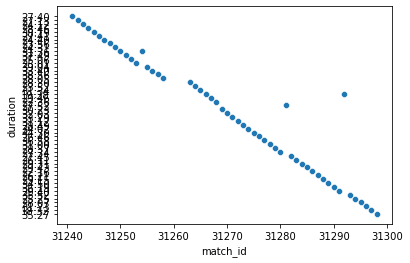

In [4]:
sns.scatterplot(x = df.match_id, y = df.duration)

In [5]:
df.match_id.tail()

49    31294
50    31295
51    31296
52    31297
53    31298
Name: match_id, dtype: int64

In [6]:
df['gold_diff_15'] = df['blue_top_gd_at_15'] + df['blue_jg_gd_at_15'] + df['blue_mid_gd_at_15'] +df['blue_bot_gd_at_15'] +df['blue_sup_gd_at_15'] - df['red_top_gd_at_15'] - df['red_jg_gd_at_15'] - df['red_mid_gd_at_15'] - df['red_bot_gd_at_15'] - df['red_sup_gd_at_15']
df['top_gold_diff_15'] = df['blue_top_gd_at_15'] - df['red_top_gd_at_15']
df['jg_gold_diff_15'] = df['blue_jg_gd_at_15'] - df['red_jg_gd_at_15']
df['mid_gold_diff_15'] = df['blue_mid_gd_at_15'] - df['red_mid_gd_at_15']
df['bot_gold_diff_15'] = df['blue_bot_gd_at_15'] - df['red_bot_gd_at_15']
df['sup_gold_diff_15'] = df['blue_sup_gd_at_15'] - df['red_sup_gd_at_15']

In [7]:
#get percentage for games in which gold lead at 15 lead to win. 
def lead_to_winrate():
    count = 0
    for index, row in df.iterrows():
        ok = df.gold_diff_15[index]
        yeet= df.result[index]
        if((ok > 0) and (yeet == 'BLUE')): 
            count+=1
        if(ok < 0 and yeet == 'RED'):
            count+=1
    win_conversion = (count/53) *100
    return  win_conversion   
          
          
          
    

In [8]:
lead_to_winrate() #79.25% win rate

79.24528301886792

In [9]:
#15 min gold lead is highly determinant of result. 
#Is a single role a better determinant than team gold diff.
def role_to_winrate(difference): 
    count = 0
    for index, row in df.iterrows():
        yeet = df.result[index]
        if((difference[index] > 0) and (yeet == "BLUE")): 
            count+=1
        if((difference[index] < 0) and (yeet == "RED")):
            count+=1
    win_conversion = (count/53) *100
    return  win_conversion 


In [10]:
role_to_winrate(df.top_gold_diff_15)  #64.15% of the time that top is ahead it's a win.

64.15094339622641

In [11]:
role_to_winrate(df.jg_gold_diff_15)  #66.04% of the time that jg is ahead it's a win.

66.0377358490566

In [12]:
role_to_winrate(df.mid_gold_diff_15) #77.36% of the time that mid is ahead it's a win.

77.35849056603774

In [13]:
role_to_winrate(df.bot_gold_diff_15) #77.36% of the time that adc is ahead it's a win.

77.35849056603774

In [14]:
role_to_winrate(df.sup_gold_diff_15) #81.13% of the time that support is ahead it's a win.

81.13207547169812

(array([17.,  4.,  9.,  1.,  4.,  6.,  2.,  8.,  1.,  2.]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <BarContainer object of 10 artists>)

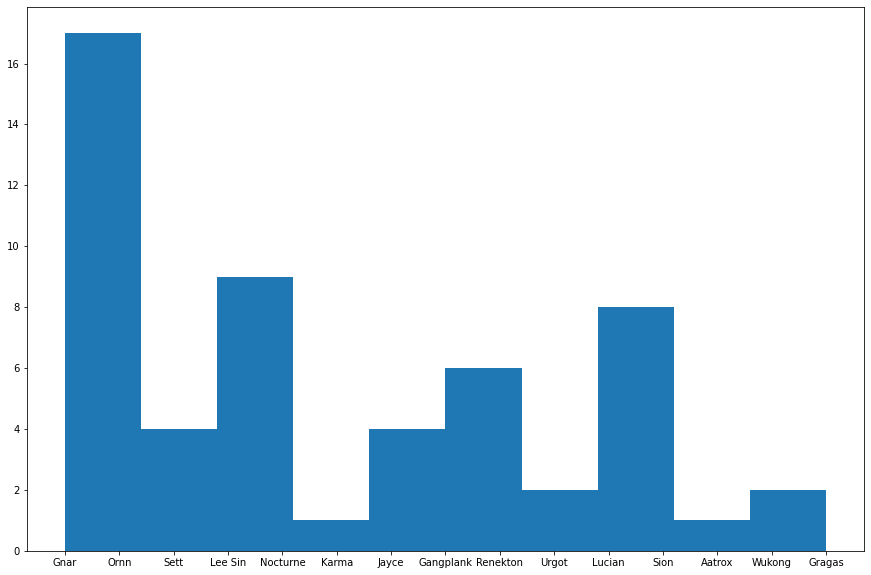

In [15]:
plt.figure(figsize =(15,10))
plt.hist(df.blue_top_champion)

(array([ 5., 16.,  5.,  5., 10.,  3.,  4.,  2.,  2.,  2.]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <BarContainer object of 10 artists>)

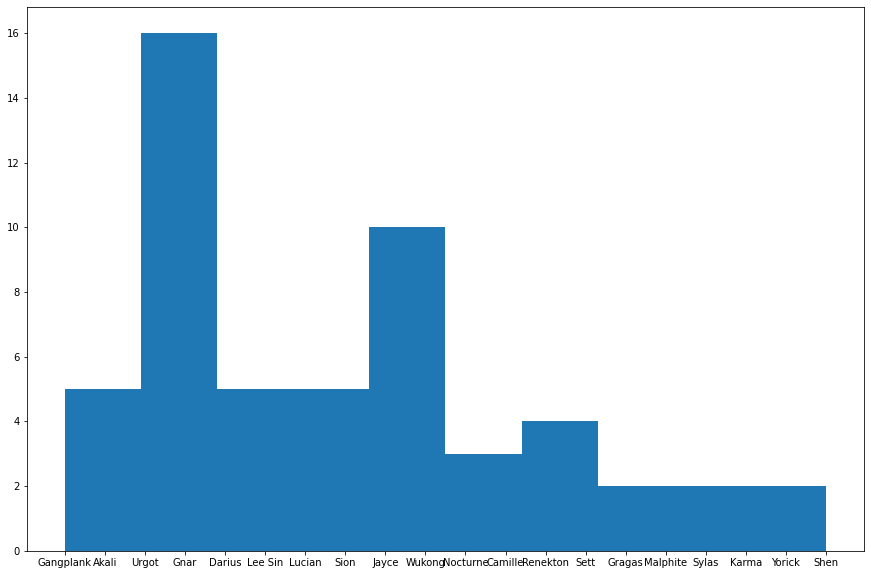

In [16]:
plt.figure(figsize =(15,10))
plt.hist(df.red_top_champion)

In [17]:
def top_champ_winrate(champion):
    count =0
    appearance = 0
    for index, row in df.iterrows():
        if df.blue_top_champion[index] == champion or df.red_top_champion[index] == champion: 
            appearance+=1
        if df.blue_top_champion[index] == champion and df.result[index] == 'BLUE': 
            count+=1
        if df.red_top_champion[index] == champion and df.result[index] == 'RED': 
            count+=1
    winrate = (count/appearance) * 100
    return winrate
def jg_champ_winrate(champion):
    count =0
    appearance = 0
    for index, row in df.iterrows():
        if df.blue_jg_champion[index] == champion or df.red_jg_champion[index] == champion: 
            appearance+=1
        if df.blue_jg_champion[index] == champion and df.result[index] == 'BLUE': 
            count+=1
        if df.red_jg_champion[index] == champion and df.result[index] == 'RED': 
            count+=1
    winrate = (count/appearance) * 100
    return winrate
def mid_champ_winrate(champion):
    count =0
    appearance = 0
    for index, row in df.iterrows():
        if df.blue_mid_champion[index] == champion or df.red_mid_champion[index] == champion: 
            appearance+=1
        if df.blue_mid_champion[index] == champion and df.result[index] == 'BLUE': 
            count+=1
        if df.red_mid_champion[index] == champion and df.result[index] == 'RED': 
            count+=1
    winrate = (count/appearance) * 100
    return winrate
def bot_champ_winrate(champion):
    count =0
    appearance = 0
    for index, row in df.iterrows():
        if df.blue_bot_champion[index] == champion or df.red_bot_champion[index] == champion: 
            appearance+=1
        if df.blue_bot_champion[index] == champion and df.result[index] == 'BLUE': 
            count+=1
        if df.red_bot_champion[index] == champion and df.result[index] == 'RED': 
            count+=1
    winrate = (count/appearance) * 100
    return winrate
def sup_champ_winrate(champion):
    count =0
    appearance = 0
    for index, row in df.iterrows():
        if df.blue_sup_champion[index] == champion or df.red_sup_champion[index] == champion: 
            appearance+=1
        if df.blue_sup_champion[index] == champion and df.result[index] == 'BLUE': 
            count+=1
        if df.red_sup_champion[index] == champion and df.result[index] == 'RED': 
            count+=1
    winrate = (count/appearance) * 100
    return winrate

In [18]:
#determine pick rate
def champ_pickrate(champion):
    appearance = 0
    for index, row in df.iterrows():
        if df.blue_top_champion[index] == champion or df.blue_jg_champion[index] == champion or df.blue_mid_champion[index] == champion or df.blue_bot_champion[index] == champion or df.blue_sup_champion[index] == champion or df.red_top_champion[index] == champion or df.red_jg_champion[index] == champion or df.red_mid_champion[index] == champion or df.red_bot_champion[index] == champion or df.red_sup_champion[index] == champion: 
            appearance+=1
    pickrate = (appearance/53) * 100
    return pickrate

def champ_winrate_all(champion):
    count = 0
    appearance = 0
    for index, row in df.iterrows():
        if df.blue_top_champion[index] == champion or df.blue_jg_champion[index] == champion or df.blue_mid_champion[index] == champion or df.blue_bot_champion[index] == champion or df.blue_sup_champion[index] == champion: 
            appearance+=1
            if df.result[index] == 'BLUE':
                count+=1
        if df.red_top_champion[index] == champion or df.red_jg_champion[index] == champion or df.red_mid_champion[index] == champion or df.red_bot_champion[index] == champion or df.red_sup_champion[index] == champion:
            appearance+=1
            if df.result[index] == 'RED':
                count+=1
    winrate = (count/appearance) * 100
    return winrate

def champ_pickrate_all(champion):
    appearance = 0
    for index, row in df.iterrows():
        if df.blue_top_champion[index] == champion or df.blue_jg_champion[index] == champion or df.blue_mid_champion[index] == champion or df.blue_bot_champion[index] == champion or df.blue_sup_champion[index] == champion: 
            appearance+=1
        if df.red_top_champion[index] == champion or df.red_jg_champion[index] == champion or df.red_mid_champion[index] == champion or df.red_bot_champion[index] == champion or df.red_sup_champion[index] == champion:
            appearance+=1
    pickrate = (appearance/53) * 100
    return pickrate

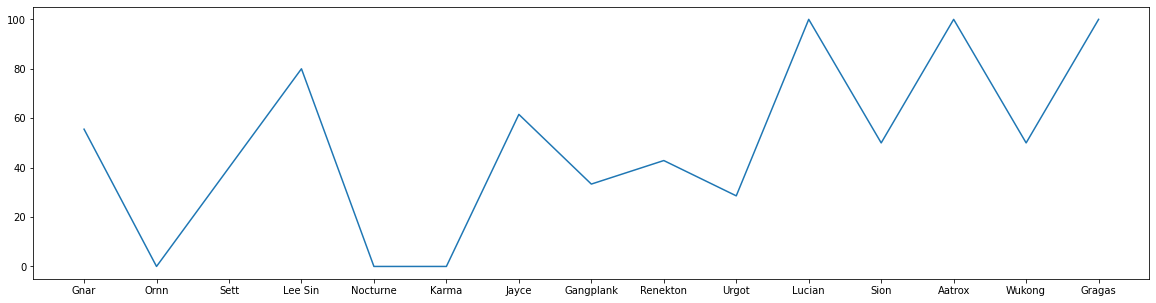

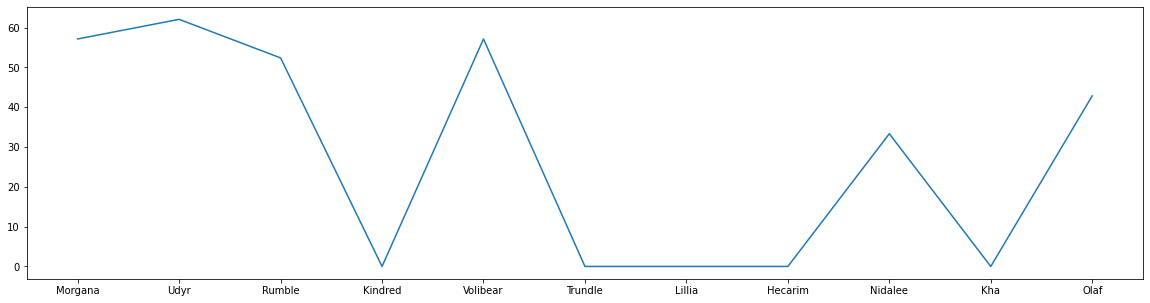

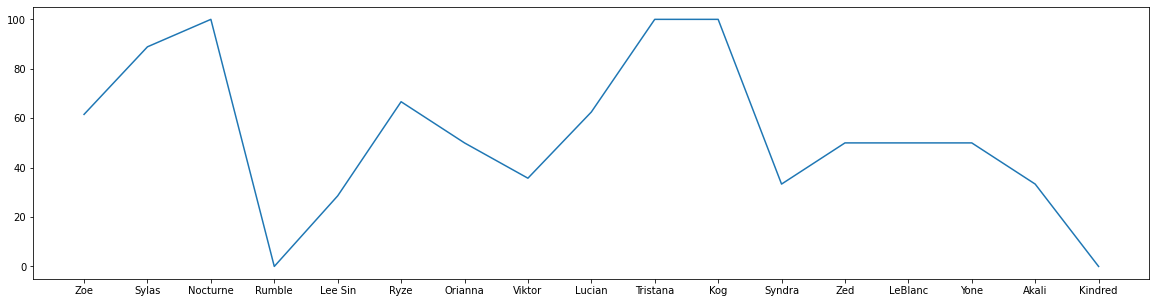

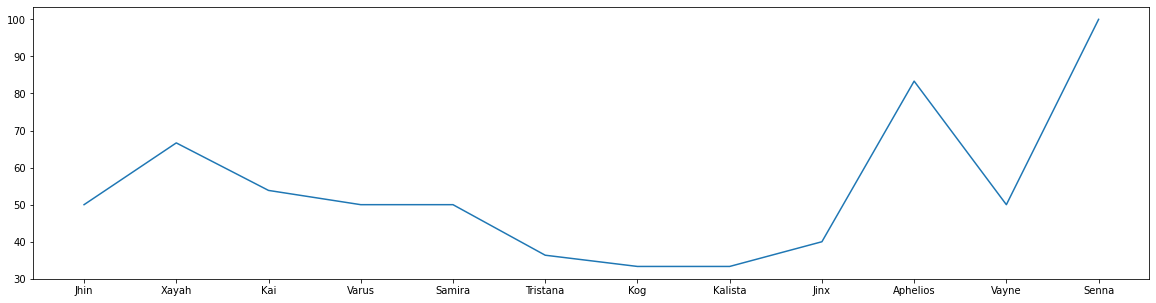

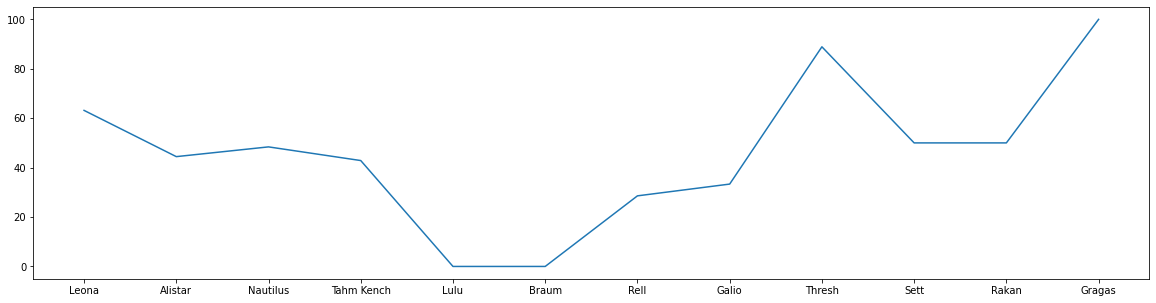

In [19]:
#TOP champ pick rate vs win rate.
champs = df.blue_top_champion
champs.add(df.red_top_champion)
top_pick_winrate = []
top_pickrate = []
top_picks = champs.unique() 
for i in range(len(top_picks)):
    check = top_picks[i]
    answer = top_champ_winrate(check)
    answer2 = champ_pickrate(check)
    top_pick_winrate.append(answer)
    top_pickrate.append(answer2)
plt.figure(figsize = (20,5))
plt.plot(top_picks, top_pick_winrate)

#JG champ pick rate vs win rate.
champs = df.blue_jg_champion
champs.add(df.red_jg_champion)
jg_pick_winrate = []
jg_pickrate = []
jg_picks = champs.unique() 
for i in range(len(jg_picks)):
    check = jg_picks[i]
    answer = jg_champ_winrate(check) 
    answer2 = champ_pickrate(check)
    jg_pick_winrate.append(answer)
    jg_pickrate.append(answer2)
plt.figure(figsize = (20,5))
plt.plot(jg_picks, jg_pick_winrate)


#MID champ pick rate vs win rate.
champs = df.blue_mid_champion
champs.add(df.red_mid_champion)
mid_pick_winrate = []
mid_pickrate = []
mid_picks = champs.unique() 
for i in range(len(mid_picks)):
    check = mid_picks[i]
    answer = mid_champ_winrate(check) 
    answer2 = champ_pickrate(check)
    mid_pick_winrate.append(answer)
    mid_pickrate.append(answer2)
plt.figure(figsize = (20,5))
plt.plot(mid_picks, mid_pick_winrate)

#BOT champ pick rate vs win rate.
champs = df.blue_bot_champion
champs.add(df.red_bot_champion)
bot_pick_winrate = []
bot_pickrate = []
bot_picks = champs.unique() 
for i in range(len(bot_picks)):
    check = bot_picks[i]
    answer = bot_champ_winrate(check)  
    answer2 = champ_pickrate(check)
    bot_pick_winrate.append(answer)
    bot_pickrate.append(answer2)
plt.figure(figsize = (20,5))
plt.plot(bot_picks, bot_pick_winrate)

#SUP champ pick rate vs win rate.
champs = df.blue_sup_champion
champs.add(df.red_sup_champion)
sup_pick_winrate = []
sup_pickrate = []
sup_picks = champs.unique() 
for i in range(len(sup_picks)):
    check = sup_picks[i]
    answer = sup_champ_winrate(check) 
    answer2 = champ_pickrate(check)
    sup_pick_winrate.append(answer)
    sup_pickrate.append(answer2)
plt.figure(figsize = (20,5))
plt.plot(sup_picks, sup_pick_winrate)

plt.show()
#top_zip = list(zip( top_pick_winrate, top_pickrate))
#jg_zip =  list(zip( jg_pick_winrate, jg_pickrate))
#mid_zip = list(zip( mid_pick_winrate, mid_pickrate))
#bot_zip = list(zip( bot_pick_winrate, bot_pickrate))
#sup_zip= list(zip( sup_pick_winrate, sup_pickrate))

#top_champ_picks = pd.DataFrame(top_zip, columns = [ 'Winrate','Pick rate'])
#jg_champ_picks = pd.DataFrame(jg_zip, columns =   ['Winrate','Pick rate'])
#mid_champ_picks = pd.DataFrame(mid_zip, columns = [ 'Winrate','Pick rate'])
#bot_champ_picks = pd.DataFrame(bot_zip, columns = [ 'Winrate','Pick rate'])
#sup_champ_picks = pd.DataFrame(sup_zip, columns = [ 'Winrate','Pick rate'])


In [20]:
#champion picks taking into account flex roles
all_champ_list = []

def get_all_champs(rawr):
    for i in range(len(rawr)):
        all_champ_list.append(rawr[i])
    

get_all_champs(df.blue_top_champion) 
get_all_champs(df.blue_jg_champion) 
get_all_champs(df.blue_mid_champion) 
get_all_champs(df.blue_bot_champion) 
get_all_champs(df.blue_sup_champion) 
get_all_champs(df.red_top_champion) 
get_all_champs(df.red_jg_champion) 
get_all_champs(df.red_mid_champion) 
get_all_champs(df.red_bot_champion) 
get_all_champs(df.red_sup_champion) 

df2 = pd.DataFrame(data = all_champ_list, columns = ['all_champ_list'])


unique_champ_list = df2.all_champ_list.unique()
flex_inc_winrate = []


for i in range(len(unique_champ_list)): 
    ok = champ_winrate_all(unique_champ_list[i])
    flex_inc_winrate.append(ok)

In [21]:
flex_inc_pickrate = []
for i in range(len(unique_champ_list)): 
    ok = champ_pickrate_all(unique_champ_list[i])
    flex_inc_pickrate.append(ok)


In [22]:
all_champ_rate = list(zip(unique_champ_list,flex_inc_pickrate ,flex_inc_winrate))
dataframe_3 = pd.DataFrame(data = all_champ_rate, columns = ['unique_champ_list','flex_pickrate','flex_winrate'])
dataframe_3.head()

,unique_champ_list,flex_pickrate,flex_winrate
0,Gnar,50.943396,55.555556
1,Ornn,1.886792,0.000000
2,Sett,18.867925,40.000000
3,Lee Sin,33.962264,55.555556
4,Nocturne,13.207547,28.571429


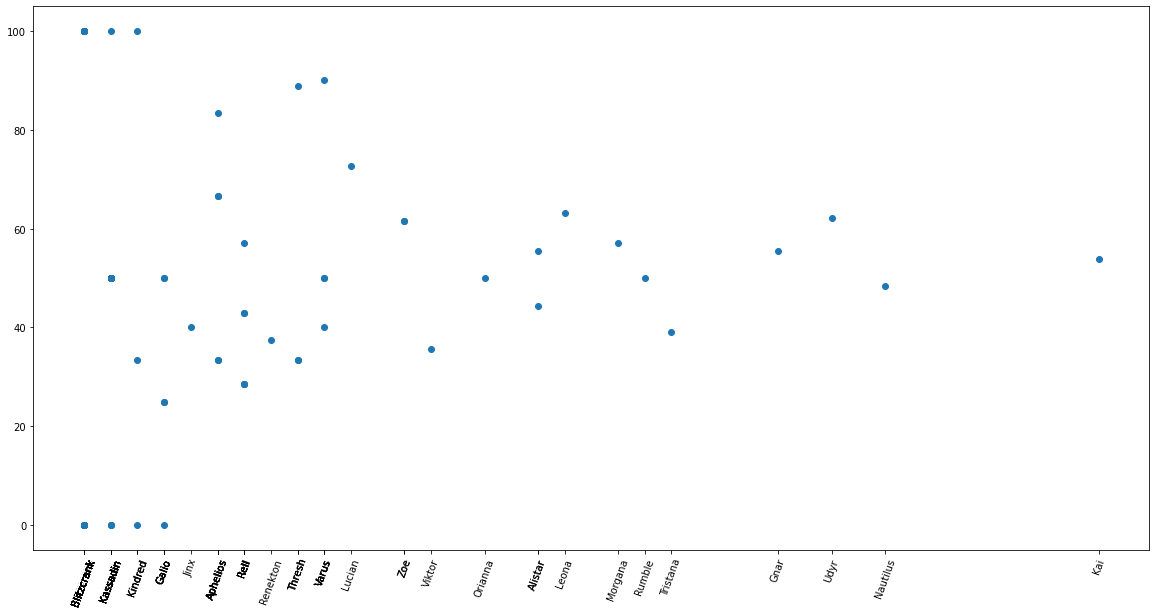

In [23]:
plt.figure(figsize = (20,10))
plt.scatter(dataframe_3.flex_pickrate, dataframe_3.flex_winrate)
plt.xticks(dataframe_3.flex_pickrate, unique_champ_list, rotation = 70)
plt.show()

In [110]:
TOOLTIPS = HoverTool(tooltips =[
    ("index", "$index"),
    ("(pick rate,win rate)", "(@flex_pickrate, @flex_winrate)"),
    ("Name", "@unique_champ_list")]
    )

p = figure(title="MSI 2021 pick rate vs win rate", x_axis_label='pick rate %', y_axis_label='win rate %', plot_width = 700, plot_height =700,tools=[TOOLTIPS])
p.circle('flex_pickrate', 'flex_winrate',size = 10, source = dataframe_3)
show(p)

(array([ 2.,  4.,  0., 10.,  9.,  8.,  8.,  5.,  5.,  3.]),
 array([119. , 140.8, 162.6, 184.4, 206.2, 228. , 249.8, 271.6, 293.4,
        315.2, 337. ]),
 <BarContainer object of 10 artists>)

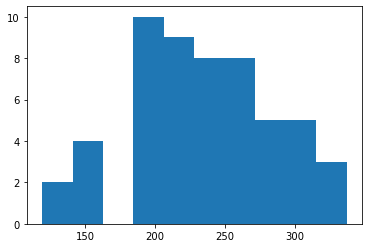

In [25]:
#check distributions
#df.columns
#plt.hist(df['blue_top_deaths'])
plt.hist(df['blue_top_cs'])


In [26]:
corrMatrix = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrMatrix, annot=True)
plt.show()
df.columns

<AxesSubplot:xlabel='blue_sup_gd_at_15', ylabel='blue_sup_deaths'>

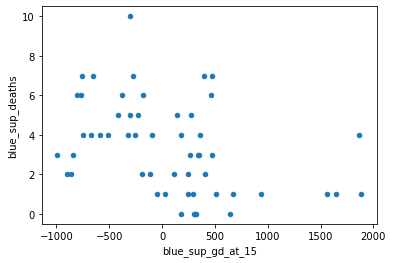

In [27]:
df.plot(kind ='scatter', x = 'blue_sup_gd_at_15', y = 'blue_sup_deaths')

In [29]:
training_model = df.drop(['timeline', 'date', 'match_id', 'duration','blue_top_kills','blue_top_deaths','blue_top_assists','blue_jg_kills', 'blue_jg_deaths', 'blue_jg_assists',
       'blue_mid_kills', 'blue_mid_deaths', 'blue_mid_assists','blue_bot_kills', 'blue_bot_deaths',
       'blue_bot_assists','blue_sup_kills',
       'blue_sup_deaths', 'blue_sup_assists','red_top_kills', 'red_top_deaths', 'red_top_assists','red_jg_kills', 'red_jg_deaths', 'red_jg_assists','red_mid_kills', 'red_mid_deaths', 'red_mid_assists','red_bot_kills', 'red_bot_deaths', 'red_bot_assists','red_sup_kills', 'red_sup_deaths', 'red_sup_assists'], axis =1)
model_target = pd.DataFrame(data = df['result'], columns =['result']) 
      

In [30]:
#model to create a mv linear regression model to predict reslts
le = preprocessing.LabelEncoder()

x = training_model
y = model_target

#Label Encoding player names
x['blue_team_name'] = le.fit_transform(x['blue_team_name'])
x['red_team_name'] = le.fit_transform(x['red_team_name'])

x['blue_top_name'] = le.fit_transform(x['blue_top_name'])
x['red_top_name'] = le.fit_transform(x['red_top_name'])

x['blue_jg_name'] = le.fit_transform(x['blue_jg_name'])
x['red_jg_name'] = le.fit_transform(x['red_jg_name'])

x['blue_mid_name'] = le.fit_transform(x['blue_mid_name'])
x['red_mid_name'] = le.fit_transform(x['red_mid_name'])

x['blue_bot_name'] = le.fit_transform(x['blue_bot_name'])
x['red_bot_name'] = le.fit_transform(x['red_bot_name'])

x['blue_sup_name'] = le.fit_transform(x['blue_sup_name'])
x['red_sup_name'] = le.fit_transform(x['red_sup_name'])

#Label Encoding champion picks
x['blue_top_champion'] = le.fit_transform(x['blue_top_champion'])
x['red_top_champion'] = le.fit_transform(x['red_top_champion'])

x['blue_jg_champion'] = le.fit_transform(x['blue_jg_champion'])
x['red_jg_champion'] = le.fit_transform(x['red_jg_champion'])

x['blue_mid_champion'] = le.fit_transform(x['blue_mid_champion'])
x['red_mid_champion'] = le.fit_transform(x['red_mid_champion'])

x['blue_bot_champion'] = le.fit_transform(x['blue_bot_champion'])
x['red_bot_champion'] = le.fit_transform(x['red_bot_champion'])

x['blue_sup_champion'] = le.fit_transform(x['blue_sup_champion'])
x['red_sup_champion'] = le.fit_transform(x['red_sup_champion'])

#turning results into 0 or 1
y = y.replace('RED', 1)
y = y.replace('BLUE', 0)
x = x.replace('RED', 1)
x = x.replace('BLUE', 0)
#predict future games by using split averages as data entries. 

In [31]:
x.shape , y.shape, 

((54, 60), (54, 1))

In [32]:
x_train, x_test, y_train ,y_test = train_test_split(x,y,test_size =0.2)
x_train.shape, y_train.shape,x_test.shape, y_test.shape

regr = linear_model.LinearRegression()
model = regr.fit(x_train,y_train)
y_pred = model.predict(x_test)
r_sq = model.score(x,y)
print("coefficient of determination:", r_sq)
print("The intercept is: {0} with a slope of:  {1}".format(model.intercept_, model.coef_))

coefficient of determination: 0.09443956306390333
The intercept is: [-3.58534451] with a slope of:  [[ 1.32820040e-01  3.61204478e-02  9.50220473e-02 -8.19804507e-04
  -2.29960685e-02  7.69350008e-02 -1.71983240e-06 -1.04805665e-02
   2.75550191e-05  3.15637057e-02  9.78500676e-02 -4.27277300e-05
   5.40853878e-03 -3.22354478e-05 -2.16573840e-02  2.99617992e-02
   1.16552660e-05 -5.21822898e-03  3.86160199e-05 -4.16424407e-02
  -4.05938648e-02  3.43672929e-05  2.03791468e-03  3.41774765e-06
  -9.81796826e-02 -7.20923106e-02 -1.23558224e-05  2.69344333e-02
  -4.48199728e-05 -1.41574137e-02  4.57748229e-03  3.94510954e-05
  -1.53143911e-03 -2.75550188e-05 -2.26360987e-02  5.63420893e-02
  -1.07580278e-04 -2.93330183e-03  3.22354479e-05 -7.39221031e-02
   2.56113950e-02 -2.87530874e-05  8.77482135e-03 -3.86160199e-05
  -2.63670027e-02  7.60453555e-02  1.03477922e-04  5.90048443e-03
  -3.41774765e-06 -5.63010120e-02  8.13365241e-02  6.20903048e-05
   5.59590371e-02  4.48199728e-05 -1.49332

In [33]:
print("Coefficients:", model.coef_)
print("Intercept:",model.intercept_)
print("Mean squared error (MSE): %.2f"% mean_squared_error(y_test, y_pred))
print("Coefficient of determination (R^2): %.2f"% r2_score(y_test, y_pred))


Coefficients: [[ 1.32820040e-01  3.61204478e-02  9.50220473e-02 -8.19804507e-04
  -2.29960685e-02  7.69350008e-02 -1.71983240e-06 -1.04805665e-02
   2.75550191e-05  3.15637057e-02  9.78500676e-02 -4.27277300e-05
   5.40853878e-03 -3.22354478e-05 -2.16573840e-02  2.99617992e-02
   1.16552660e-05 -5.21822898e-03  3.86160199e-05 -4.16424407e-02
  -4.05938648e-02  3.43672929e-05  2.03791468e-03  3.41774765e-06
  -9.81796826e-02 -7.20923106e-02 -1.23558224e-05  2.69344333e-02
  -4.48199728e-05 -1.41574137e-02  4.57748229e-03  3.94510954e-05
  -1.53143911e-03 -2.75550188e-05 -2.26360987e-02  5.63420893e-02
  -1.07580278e-04 -2.93330183e-03  3.22354479e-05 -7.39221031e-02
   2.56113950e-02 -2.87530874e-05  8.77482135e-03 -3.86160199e-05
  -2.63670027e-02  7.60453555e-02  1.03477922e-04  5.90048443e-03
  -3.41774765e-06 -5.63010120e-02  8.13365241e-02  6.20903048e-05
   5.59590371e-02  4.48199728e-05 -1.49332688e-05  5.51100377e-05
  -6.44708959e-05  7.72320398e-05  6.83549538e-06 -8.96399456e

In [34]:
x.columns

Index(['blue_team_name', 'red_team_name', 'result', 'duration_in_sec',
       'blue_top_name', 'blue_top_champion', 'blue_top_kda', 'blue_top_cs',
       'blue_top_gd_at_15', 'blue_jg_name', 'blue_jg_champion', 'blue_jg_kda',
       'blue_jg_cs', 'blue_jg_gd_at_15', 'blue_mid_name', 'blue_mid_champion',
       'blue_mid_kda', 'blue_mid_cs', 'blue_mid_gd_at_15', 'blue_bot_name',
       'blue_bot_champion', 'blue_bot_kda', 'blue_bot_cs', 'blue_bot_gd_at_15',
       'blue_sup_name', 'blue_sup_champion', 'blue_sup_kda', 'blue_sup_cs',
       'blue_sup_gd_at_15', 'red_top_name', 'red_top_champion', 'red_top_kda',
       'red_top_cs', 'red_top_gd_at_15', 'red_jg_name', 'red_jg_champion',
       'red_jg_kda', 'red_jg_cs', 'red_jg_gd_at_15', 'red_mid_name',
       'red_mid_champion', 'red_mid_kda', 'red_mid_cs', 'red_mid_gd_at_15',
       'red_bot_name', 'red_bot_champion', 'red_bot_kda', 'red_bot_cs',
       'red_bot_gd_at_15', 'red_sup_name', 'red_sup_champion', 'red_sup_kda',
       'red_su

In [35]:
corrMatrix = training_model.corr().abs()
#plt.figure(figsize=(20,20))
#sns.heatmap(corrMatrix, annot=True)


s= corrMatrix.unstack()
so = s.sort_values(kind="quicksort")


In [36]:
y_pred = y_pred.astype(int)
y_pred = np.vstack( y_pred )


def cumulate(list, together_list): 
    for i in range(len(list)): 
        together_list.append(list[i])
    return together_list


In [37]:
import itertools
yeet = y_test["result"].to_list()
ok =  list(itertools.chain.from_iterable(y_pred))

Text(0, 0.5, 'y_pred')

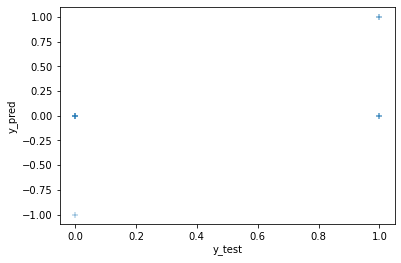

In [38]:
sns.scatterplot(x = yeet,y= ok, marker= "+")
plt.xlabel("y_test")
plt.ylabel("y_pred")

In [39]:
#logistic regression 
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [40]:
#generate dataset
yeet,ok = make_classification(
n_samples = 100, 
n_features  =1,
n_classes = 2,
n_clusters_per_class = 1,
flip_y = 0.03,
n_informative = 1,
n_redundant = 0,
n_repeated =0
)

Text(0.5, 1.0, 'Scatter Plot of Logistic Regression')

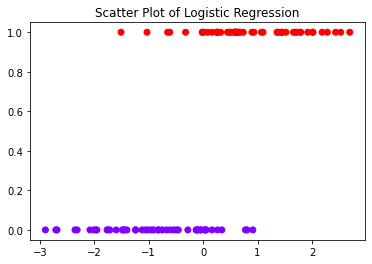

In [41]:
plt.scatter(yeet,ok,c = ok, cmap = 'rainbow')
plt.title('Scatter Plot of Logistic Regression')

In [42]:
x_train, x_test, y_train, y_test = train_test_split(yeet, ok,random_state= 1)

In [43]:
#perform logistic regression
log_reg = LogisticRegression()
log_reg.fit(x_train,y_train)

LogisticRegression()

In [44]:
print(log_reg.coef_)
print(log_reg.intercept_)

[[1.85428469]]
[-0.03595713]


In [45]:
#make predictions
y_pred = log_reg.predict(x_test)

In [46]:
confusion_matrix(y_test,y_pred)
#upper left - true positive
#lower left - false negatives
#upper right - false positives
#lower right - true negatives

array([[ 8,  3],
       [ 3, 11]], dtype=int64)

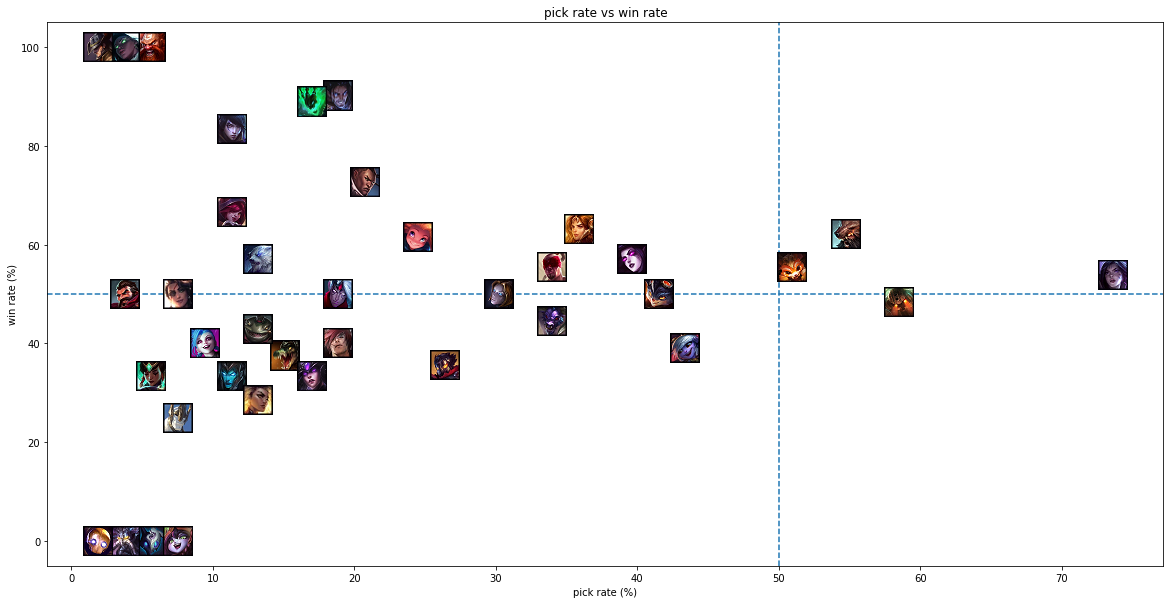

In [109]:
#infographic displaying pick rate vs winrate. using png icons for each champion

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path): 
    return OffsetImage(plt.imread(path))

paths = [
    'champ_png/gnar.png',
    'champ_png/ornn.png',
    'champ_png/sett.png',
    'champ_png/lee_sin.png',
    'champ_png/nocturne.png',
    'champ_png/karma.png',
    'champ_png/jayce.png',
    'champ_png/gangplank.png',
    'champ_png/renekton.png',
    'champ_png/urgot.png',
    'champ_png/lucian.png',
    'champ_png/sion.png',
    'champ_png/aatrox.png',
    'champ_png/wukong.png',
    'champ_png/gragas.png',
    'champ_png/morgana.png',
    'champ_png/udyr.png',
    'champ_png/rumble.png',
    'champ_png/kindred.png',
    'champ_png/volibear.png',
    'champ_png/trundle.png',
    'champ_png/lillia.png',
    'champ_png/hecarim.png',
    'champ_png/nidalee.png',
    'champ_png/khazix.png',
    'champ_png/olaf.png',
    'champ_png/zoe.png',
    'champ_png/sylas.png',
    'champ_png/ryze.png',
    'champ_png/orianna.png',
    'champ_png/viktor.png',
    'champ_png/tristana.png',
    'champ_png/kogmaw.png',
    'champ_png/syndra.png',
    'champ_png/zed.png',
    'champ_png/leblanc.png',
    'champ_png/yone.png',
    'champ_png/akali.png',
    'champ_png/jhin.png',
    'champ_png/xayah.png',
    'champ_png/kaisa.png',
    'champ_png/varus.png',
    'champ_png/samira.png',
    'champ_png/kalista.png',
    'champ_png/jinx.png',
    'champ_png/aphelios.png',
    'champ_png/vayne.png',
    'champ_png/senna.png',
    'champ_png/leona.png',
    'champ_png/alistar.png',
    'champ_png/nautilus.png',
    'champ_png/tahmkench.png',
    'champ_png/lulu.png',
    'champ_png/braum.png',
    'champ_png/rell.png',
    'champ_png/galio.png',
    'champ_png/thresh.png',
    'champ_png/rakan.png',
    'champ_png/darius.png',
    'champ_png/camille.png',
    'champ_png/malphite.png',
    'champ_png/yorick.png',
    'champ_png/shen.png',
    'champ_png/fiddlesticks.png',
    'champ_png/graves.png',
    'champ_png/karthus.png',
    'champ_png/diana.png',
    'champ_png/kassadin.png',
    'champ_png/ahri.png',
    'champ_png/qiyana.png',
    'champ_png/vladimir.png',
    'champ_png/azir.png',
    'champ_png/yasuo.png',
    'champ_png/twistedfate.png',
    'champ_png/ashe.png',
    'champ_png/blitzcrank.png']
    #image places for each character in order based on unique_champ_list 
#unique_champ_list

x = dataframe_3.flex_pickrate
y = dataframe_3.flex_winrate

fig, ax = plt.subplots(figsize = (20,10))
plt.xlabel("pick rate (%)")
plt.ylabel("win rate (%)")
plt.title("pick rate vs win rate")
ax.scatter(x,y)
ax.axvline(x = 50, linestyle = '--')
ax.axhline(y = 50, linestyle = '--')
for x0,y0,path in zip(x,y,paths):
    ab = AnnotationBbox(getImage(path), (x0,y0), frameon = False)
    ax.add_artist(ab)

Index(['match_id', 'blue_team_name', 'red_team_name', 'result', 'duration',
       'duration_in_sec', 'date', 'blue_top_name', 'blue_top_champion',
       'blue_top_kills', 'blue_top_deaths', 'blue_top_assists', 'blue_top_kda',
       'blue_top_cs', 'blue_top_gd_at_15', 'blue_jg_name', 'blue_jg_champion',
       'blue_jg_kills', 'blue_jg_deaths', 'blue_jg_assists', 'blue_jg_kda',
       'blue_jg_cs', 'blue_jg_gd_at_15', 'blue_mid_name', 'blue_mid_champion',
       'blue_mid_kills', 'blue_mid_deaths', 'blue_mid_assists', 'blue_mid_kda',
       'blue_mid_cs', 'blue_mid_gd_at_15', 'blue_bot_name',
       'blue_bot_champion', 'blue_bot_kills', 'blue_bot_deaths',
       'blue_bot_assists', 'blue_bot_kda', 'blue_bot_cs', 'blue_bot_gd_at_15',
       'blue_sup_name', 'blue_sup_champion', 'blue_sup_kills',
       'blue_sup_deaths', 'blue_sup_assists', 'blue_sup_kda', 'blue_sup_cs',
       'blue_sup_gd_at_15', 'red_top_name', 'red_top_champion',
       'red_top_kills', 'red_top_deaths', 'red_top

In [68]:
unique_champ_list

array(['Gnar', 'Ornn', 'Sett', 'Lee Sin', 'Nocturne', 'Karma', 'Jayce',
       'Gangplank', 'Renekton', 'Urgot', 'Lucian', 'Sion', 'Aatrox',
       'Wukong', 'Gragas', 'Morgana', 'Udyr', 'Rumble', 'Kindred',
       'Volibear', 'Trundle', 'Lillia', 'Hecarim', 'Nidalee', 'Kha',
       'Olaf', 'Zoe', 'Sylas', 'Ryze', 'Orianna', 'Viktor', 'Tristana',
       'Kog', 'Syndra', 'Zed', 'LeBlanc', 'Yone', 'Akali', 'Jhin',
       'Xayah', 'Kai', 'Varus', 'Samira', 'Kalista', 'Jinx', 'Aphelios',
       'Vayne', 'Senna', 'Leona', 'Alistar', 'Nautilus', 'Tahm Kench',
       'Lulu', 'Braum', 'Rell', 'Galio', 'Thresh', 'Rakan', 'Darius',
       'Camille', 'Malphite', 'Yorick', 'Shen', 'Fiddlesticks', 'Graves',
       'Karthus', 'Diana', 'Kassadin', 'Ahri', 'Qiyana', 'Vladimir',
       'Azir', 'Yasuo', 'Twisted Fate', 'Ashe', 'Blitzcrank'],
      dtype=object)